# load library

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 26 03:42:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install torchnet

In [ ]:
#torch

from torch.nn import Parameter
import torch
import torch.optim
import torch.optim as optim
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

import torch.utils.data as Data
import torch.backends.cudnn as cudnn


#torchnet???
#import torchnet as tnt


#numpy
import numpy as np

#pandas
import pandas as pd

#utility

import math
from urllib.request import urlretrieve

from PIL import Image
#from tqdm import tqdm
from tqdm.auto import tqdm
import random

import json
import os
import pickle
import shutil
import time


#initialize hyperparameter

In [ ]:
use_gpu = torch.cuda.is_available()

image_size = 224

batch_size = 64

num_classes = 23

#workers = 25
workers = 4

#device_ids = None

#evaluate = False

#start_epoch = 0

max_epochs = 1

#epoch_step = []

#use_pb = True

# define utility class & function

In [ ]:
class Warp(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = int(size)
        self.interpolation = interpolation

    def __call__(self, img):
        return img.resize((self.size, self.size), self.interpolation)

    def __str__(self):
        return self.__class__.__name__ + ' (size={size}, interpolation={interpolation})'.format(size=self.size,
                                                                                                interpolation=self.interpolation)
class MultiScaleCrop(object):

    def __init__(self, input_size, scales=None, max_distort=1, fix_crop=True, more_fix_crop=True):
        self.scales = scales if scales is not None else [1, 875, .75, .66]
        self.max_distort = max_distort
        self.fix_crop = fix_crop
        self.more_fix_crop = more_fix_crop
        self.input_size = input_size if not isinstance(input_size, int) else [input_size, input_size]
        self.interpolation = Image.BILINEAR

    def __call__(self, img):
        im_size = img.size
        crop_w, crop_h, offset_w, offset_h = self._sample_crop_size(im_size)
        crop_img_group = img.crop((offset_w, offset_h, offset_w + crop_w, offset_h + crop_h))
        ret_img_group = crop_img_group.resize((self.input_size[0], self.input_size[1]), self.interpolation)
        return ret_img_group

    def _sample_crop_size(self, im_size):
        image_w, image_h = im_size[0], im_size[1]

        # find a crop size
        base_size = min(image_w, image_h)
        crop_sizes = [int(base_size * x) for x in self.scales]
        crop_h = [self.input_size[1] if abs(x - self.input_size[1]) < 3 else x for x in crop_sizes]
        crop_w = [self.input_size[0] if abs(x - self.input_size[0]) < 3 else x for x in crop_sizes]

        pairs = []
        for i, h in enumerate(crop_h):
            for j, w in enumerate(crop_w):
                if abs(i - j) <= self.max_distort:
                    pairs.append((w, h))

        crop_pair = random.choice(pairs)
        if not self.fix_crop:
            w_offset = random.randint(0, image_w - crop_pair[0])
            h_offset = random.randint(0, image_h - crop_pair[1])
        else:
            w_offset, h_offset = self._sample_fix_offset(image_w, image_h, crop_pair[0], crop_pair[1])

        return crop_pair[0], crop_pair[1], w_offset, h_offset

    def _sample_fix_offset(self, image_w, image_h, crop_w, crop_h):
        offsets = self.fill_fix_offset(self.more_fix_crop, image_w, image_h, crop_w, crop_h)
        return random.choice(offsets)

    @staticmethod
    def fill_fix_offset(more_fix_crop, image_w, image_h, crop_w, crop_h):
        w_step = (image_w - crop_w) // 4
        h_step = (image_h - crop_h) // 4

        ret = list()
        ret.append((0, 0))  # upper left
        ret.append((4 * w_step, 0))  # upper right
        ret.append((0, 4 * h_step))  # lower left
        ret.append((4 * w_step, 4 * h_step))  # lower right
        ret.append((2 * w_step, 2 * h_step))  # center

        if more_fix_crop:
            ret.append((0, 2 * h_step))  # center left
            ret.append((4 * w_step, 2 * h_step))  # center right
            ret.append((2 * w_step, 4 * h_step))  # lower center
            ret.append((2 * w_step, 0 * h_step))  # upper center

            ret.append((1 * w_step, 1 * h_step))  # upper left quarter
            ret.append((3 * w_step, 1 * h_step))  # upper right quarter
            ret.append((1 * w_step, 3 * h_step))  # lower left quarter
            ret.append((3 * w_step, 3 * h_step))  # lower righ quarter

        return ret


    def __str__(self):
        return self.__class__.__name__


def download_url(url, destination=None, progress_bar=True):
    """Download a URL to a local file.

    Parameters
    ----------
    url : str
        The URL to download.
    destination : str, None
        The destination of the file. If None is given the file is saved to a temporary directory.
    progress_bar : bool
        Whether to show a command-line progress bar while downloading.

    Returns
    -------
    filename : str
        The location of the downloaded file.

    Notes
    -----
    Progress bar use/example adapted from tqdm documentation: https://github.com/tqdm/tqdm
    """

    def my_hook(t):
        last_b = [0]

        def inner(b=1, bsize=1, tsize=None):
            if tsize is not None:
                t.total = tsize
            if b > 0:
                t.update((b - last_b[0]) * bsize)
            last_b[0] = b

        return inner

    if progress_bar:
        with tqdm(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
            filename, _ = urlretrieve(url, filename=destination, reporthook=my_hook(t))
    else:
        filename, _ = urlretrieve(url, filename=destination)


class AveragePrecisionMeter(object):
    """
    The APMeter measures the average precision per class.
    The APMeter is designed to operate on `NxK` Tensors `output` and
    `target`, and optionally a `Nx1` Tensor weight where (1) the `output`
    contains model output scores for `N` examples and `K` classes that ought to
    be higher when the model is more convinced that the example should be
    positively labeled, and smaller when the model believes the example should
    be negatively labeled (for instance, the output of a sigmoid function); (2)
    the `target` contains only values 0 (for negative examples) and 1
    (for positive examples); and (3) the `weight` ( > 0) represents weight for
    each sample.
    """

    def __init__(self, difficult_examples=False):
        super(AveragePrecisionMeter, self).__init__()
        self.reset()
        self.difficult_examples = difficult_examples

    def reset(self):
        """Resets the meter with empty member variables"""
        self.scores = torch.FloatTensor(torch.FloatStorage())
        self.targets = torch.LongTensor(torch.LongStorage())

    def add(self, output, target):
        """
        Args:
            output (Tensor): NxK tensor that for each of the N examples
                indicates the probability of the example belonging to each of
                the K classes, according to the model. The probabilities should
                sum to one over all classes
            target (Tensor): binary NxK tensort that encodes which of the K
                classes are associated with the N-th input
                    (eg: a row [0, 1, 0, 1] indicates that the example is
                         associated with classes 2 and 4)
            weight (optional, Tensor): Nx1 tensor representing the weight for
                each example (each weight > 0)
        """
        if not torch.is_tensor(output):
            output = torch.from_numpy(output)
        if not torch.is_tensor(target):
            target = torch.from_numpy(target)

        if output.dim() == 1:
            output = output.view(-1, 1)
        else:
            assert output.dim() == 2, \
                'wrong output size (should be 1D or 2D with one column \
                per class)'
        if target.dim() == 1:
            target = target.view(-1, 1)
        else:
            assert target.dim() == 2, \
                'wrong target size (should be 1D or 2D with one column \
                per class)'
        if self.scores.numel() > 0:
            assert target.size(1) == self.targets.size(1), \
                'dimensions for output should match previously added examples.'

        # make sure storage is of sufficient size
        if self.scores.storage().size() < self.scores.numel() + output.numel():
            new_size = math.ceil(self.scores.storage().size() * 1.5)
            self.scores.storage().resize_(int(new_size + output.numel()))
            self.targets.storage().resize_(int(new_size + output.numel()))

        # store scores and targets
        offset = self.scores.size(0) if self.scores.dim() > 0 else 0
        self.scores.resize_(offset + output.size(0), output.size(1))
        self.targets.resize_(offset + target.size(0), target.size(1))
        self.scores.narrow(0, offset, output.size(0)).copy_(output)
        self.targets.narrow(0, offset, target.size(0)).copy_(target)

    def value(self):
        """Returns the model's average precision for each class
        Return:
            ap (FloatTensor): 1xK tensor, with avg precision for each class k
        """

        if self.scores.numel() == 0:
            return 0
        ap = torch.zeros(self.scores.size(1))
        rg = torch.arange(1, self.scores.size(0)).float()
        # compute average precision for each class
        for k in range(self.scores.size(1)):
            # sort scores
            scores = self.scores[:, k]
            targets = self.targets[:, k]
            # compute average precision
            ap[k] = AveragePrecisionMeter.average_precision(scores, targets, self.difficult_examples)
        return ap

    @staticmethod
    def average_precision(output, target, difficult_examples=True):

        # sort examples
        sorted, indices = torch.sort(output, dim=0, descending=True)

        # Computes prec@i
        pos_count = 0.
        total_count = 0.
        precision_at_i = 0.
        for i in indices:
            label = target[i]
            if difficult_examples and label == 0:
                continue
            if label == 1:
                pos_count += 1
            total_count += 1
            if label == 1:
                precision_at_i += pos_count / total_count
        precision_at_i /= pos_count
        return precision_at_i

    def overall(self):
        if self.scores.numel() == 0:
            return 0
        scores = self.scores.cpu().numpy()
        targets = self.targets.cpu().numpy()
        targets[targets == -1] = 0
        return self.evaluation(scores, targets)

    def overall_topk(self, k):
        targets = self.targets.cpu().numpy()
        targets[targets == -1] = 0
        n, c = self.scores.size()
        scores = np.zeros((n, c)) - 1
        index = self.scores.topk(k, 1, True, True)[1].cpu().numpy()
        tmp = self.scores.cpu().numpy()
        for i in range(n):
            for ind in index[i]:
                scores[i, ind] = 1 if tmp[i, ind] >= 0 else -1
        return self.evaluation(scores, targets)


    def evaluation(self, scores_, targets_):
        n, n_class = scores_.shape
        Nc, Np, Ng = np.zeros(n_class), np.zeros(n_class), np.zeros(n_class)
        for k in range(n_class):
            scores = scores_[:, k]
            targets = targets_[:, k]
            targets[targets == -1] = 0
            Ng[k] = np.sum(targets == 1)
            Np[k] = np.sum(scores >= 0)
            Nc[k] = np.sum(targets * (scores >= 0))
        Np[Np == 0] = 1
        OP = np.sum(Nc) / np.sum(Np)
        OR = np.sum(Nc) / np.sum(Ng)
        OF1 = (2 * OP * OR) / (OP + OR)

        CP = np.sum(Nc / Np) / n_class
        CR = np.sum(Nc / Ng) / n_class
        CF1 = (2 * CP * CR) / (CP + CR)
        return OP, OR, OF1, CP, CR, CF1

def top_n_recall(preds, truths, n=1):
    best_n = np.argsort(preds, axis=1)[:,-n:]
    ts = np.argmax(truths, axis=1)
    successes = 0
    s_img_id = []
    w_img_id = []
    for i in range(ts.shape[0]):
        if ts[i] in best_n[i,:]:
            successes += 1
            s_img_id.append(i)
        else:
            w_img_id.append(i)

    return float(successes)/ts.shape[0], s_img_id, w_img_id, best_n

def gen_A(num_classes, t, adj_file):
    import pickle
    result = pickle.load(open(adj_file, 'rb'))
    _adj = result['adj']
    _nums = result['nums']
    _nums = _nums[:, np.newaxis]
    _adj = _adj / _nums
    _adj[_adj < t] = 0
    _adj[_adj >= t] = 1
    _adj = _adj * 0.25 / (_adj.sum(0, keepdims=True) + 1e-6)
    _adj = _adj + np.identity(num_classes, np.int)
    return _adj

def gen_adj(A):
    D = torch.pow(A.sum(1).float(), -0.5)
    D = torch.diag(D)
    adj = torch.matmul(torch.matmul(A, D).t(), D)
    return adj

# load train & val data

In [ ]:
#define label

# label = {"classic": 0,
#          "preppy":1, 
#          "manish": 2,
#          "tomboy":3, 
#          "feminine": 4,
#          "romantic": 5,
#          "sexy": 6,
#          "hippie": 7,
#          "western": 8,
#          "oriental": 9,
#          "modern": 10,
#          "sophisticated": 11,
#          "avantgarde": 12,
#          "country": 13,
#          "resort": 14,
#          "genderless": 15,
#          "sporty": 16,
#          "retro": 17,
#          "hiphop": 18,
#          "kitsch": 19,
#          "punk": 20,
#          "street": 21,
#          "military":22
#          }

label = {"클래식": 0,
         "프레피":1, 
         "매니시": 2,
         "톰보이":3, 
         "페미닌": 4,
         "로맨틱": 5,
         "섹시": 6,
         "히피": 7,
         "웨스턴": 8,
         "오리엔탈": 9,
         "모던": 10,
         "소피스트케이티드": 11,
         "아방가르드": 12,
         "컨트리": 13,
         "리조트": 14,
         "젠더리스": 15,
         "스포티": 16,
         "레트로": 17,
         "힙합": 18,
         "키치": 19,
         "펑크": 20,
         "스트리트": 21,
         "밀리터리":22
         }

In [ ]:
#load adj

## Load pickle
with open("/content/drive/MyDrive/pickle/adj_file.pkl","rb") as fr:
    adj = pickle.load(fr)

print(adj)

{'nums': array([14380,  3008,  4785,  8770, 19124, 19016,  6655,  7080,  2011,
        4481, 19262, 12916,  4109, 12896, 12184, 13870, 11070,  7941,
         575,  5276,   619, 44458,  3841]), 'adj': array([[   0,  410,  514,  250, 2131,  356,   27,    0,   68,   15, 1542,
         693,   61,  235,  252,  999,    9,  161,    0,   60,    0, 1950,
          68],
       [ 410,    0,   20,  116,  225,  199,    0,    0,   11,    0,  136,
           5,    0,   49,    0,   27,    0,   29,    0,   34,    0,  434,
           0],
       [ 514,   20,    0,  780,   41,   74,   35,    0,    0,    3,  412,
         389,   13,   54,   44,  521,    8,   14,    0,    1,    0,  746,
          32],
       [ 250,  116,  780,    0,   58,   53,    0,   12,    5,    0,  325,
         178,   28,  188,  221,  725,   55,   51,   15,   98,    8, 2703,
          38],
       [2131,  225,   41,   58,    0, 3255,  896,  254,  152,  298, 1720,
        1484,  153,  929,  893,   70,  137,  829,    0,   94,   38, 1619,


In [ ]:
## Load word2vec
with open("/content/drive/MyDrive/pickle/custom_word2vec.pkl","rb") as fr:
    word2vec = pickle.load(fr)
print(word2vec)

[[ 0.2890625   0.06982422  0.16210938 ... -0.12451172  0.02148438
  -0.04370117]
 [ 0.03930664  0.10595703 -0.18359375 ... -0.21484375  0.16113281
   0.36132812]
 [-0.14550781  0.03637695  0.05175781 ... -0.0625     -0.07910156
   0.02819824]
 ...
 [ 0.05224609 -0.03808594  0.20410156 ... -0.265625    0.09570312
   0.14355469]
 [ 0.09814453  0.07568359  0.03088379 ... -0.04833984  0.21289062
  -0.13867188]
 [-0.03442383  0.21679688 -0.09472656 ... -0.04003906  0.15527344
   0.10009766]]


In [ ]:
## Load train_data_list
with open("/content/drive/MyDrive/pickle/train_data_annotation.pkl","rb") as fr:
    train_data_list = pickle.load(fr)
print(len(train_data_list))

152757


In [ ]:
## Load val_data_list
with open("/content/drive/MyDrive/pickle/val_data_annotation.pkl","rb") as fr:
    val_data_list = pickle.load(fr)
print(len(val_data_list))

34867


# load data_path

In [ ]:
train_data_filename_list = {}

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

In [ ]:
import os

In [ ]:
#random moving data >= 10000

data_list = os.listdir(f"/content/drive/MyDrive/fashiondata/Valdata/val/스트리트")    

train_data_filename_list[(2,"스트리트")] = data_list

In [ ]:
len(data_list)

55879

In [ ]:
len(train_data_filename_list.keys())

23

In [ ]:
with open("/content/drive/MyDrive/pickle/train_street.pkl","wb") as fw:
    pickle.dump(data_list, fw)

In [ ]:
## check
with open("/content/drive/MyDrive/pickle/train_filename_v1.pkl","rb") as fr:
    data_list = pickle.load(fr)

In [ ]:
len(data_list.keys())

23

In [ ]:
train_data_filename_list[(3,"톰보이")] = data_list

In [ ]:
len(data_list)

11179

In [ ]:
random_data = np.random.choice(data_list,44700,replace=False)

In [ ]:
len(set(random_data))

44700

In [ ]:
data_list = os.listdir("/content/drive/MyDrive/fashiondata/data/train1/리조트")


In [ ]:
label_list = os.listdir("/content/drive/MyDrive/fashiondata/label/Training/리조트")


In [ ]:
len(data_list)

73181

In [ ]:
len(label_list)

83181

In [ ]:
len(random_data)

44700

#data moving

In [ ]:
label_list[2165]

'1144172.json'

In [ ]:
len(data_list)

10000

In [ ]:
path = "/content/drive/MyDrive/fashiondata/data/train1/리조트/"

filename_list = []

for labelname in tqdm(label_list):
    
    filename = labelname[:-5] + ".jpg"

    try:

        shutil.move(path+filename, "/content/drive/MyDrive/fashiondata/style/data/train/리조트")
    
    except:

        filename_list.append(labelname)

  0%|          | 0/83181 [00:00<?, ?it/s]

In [ ]:
len(filename_list)

10000

In [ ]:
path = "/content/drive/MyDrive/fashiondata/label/Training/리조트/"

count = 0

for labelname in tqdm(label_list):
    
    if labelname in filename_list:
        
        count += 1
        continue
    
    else:

        shutil.move(path+labelname, "/content/drive/MyDrive/fashiondata/style/label/train/리조트")

print(count)

  0%|          | 0/83181 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
path = "/content/drive/MyDrive/fashiondata/label/Validation/스트리트/"

count = 0

for filename in tqdm(random_data):
    
    labelname = filename[:-4] + ".json"

    try:

        shutil.move(path+labelname, "/content/drive/MyDrive/fashiondata/style/label/train/스트리트")
    
    except:

        os.remove("/content/drive/MyDrive/fashiondata/style/label/train/스트리트" + filename)      
        count += 1

print(count)

  0%|          | 0/44700 [00:00<?, ?it/s]

0


In [ ]:
#initialization class array & adj array

nums = [0]*23
adj = [[0]*23 for _ in range(23)]

In [ ]:
train1 = ["레트로","로맨틱","리조트","매니시","모던","밀리터리","섹시","소피스트케이티드"]
train2 = ["스트리트"]
train3 = ["스포티","아방가르드","오리엔탈","웨스턴","젠더리스","컨트리","클래식","키치","톰보이","펑크","페미닌","프레피","히피","힙합"]

class_name = [train1,train2,train3]

train_data_list = []

In [ ]:
#preprocessing

train_data_filename_list = {}

for i in tqdm(range(3)):
    
    for c in class_name[i]:
        
        #random sample 200

        data_list = os.listdir(f"/content/drive/MyDrive/fashiondata/data/train{i+1}/{c}")

        train_data_filename_list[(i+1,c)] = data_list

        print(c,":",len(data_list))

  0%|          | 0/3 [00:00<?, ?it/s]

레트로 : 6833


OSError: ignored

In [ ]:
sum([6833,73173,83181,8488,79555,3633,6322,32598,14701,3671,4069,1712,11980,32114,39383,4680,7578,382,87871,2471,6516,200])

511111

In [ ]:
#create total train_data

special = ["로맨틱","리조트","모던","소피스트케이티드","스포티","젠더리스","컨트리","페미닌"]

train_data_list = []

for (i,c),value in train_data_filename_list.items():
    
    if c in special:
        
        root_path = f"/content/drive/MyDrive/fashiondata/data/train{i}/{c}1/"
    
    else:
        
        root_path = f"/content/drive/MyDrive/fashiondata/data/train{i}/{c}/"
    
    label_path = f"/content/drive/MyDrive/fashiondata/label/Training/{c}/"

    for file_name in tqdm(value):
        
        json_name = file_name[:-4] + ".json"
        
        labels = []

        train_data = {}

        try:

            with open(f"{label_path}{json_name}","r") as fr:
                
                data = json.load(fr)

                label_dict = data['데이터셋 정보']['데이터셋 상세설명']['라벨링']['스타일'][0]

                for key in label_dict:

                    labels.append(label[label_dict[key]])

                    nums[label[label_dict[key]]] += 1
                
                if len(labels) == 2:
                    
                    A = labels[0]
                    B = labels[1]

                    adj[A][B] += 1
                    adj[B][A] += 1

                file_name = root_path + file_name 

                train_data["file_name"] = file_name
                train_data["labels"] = labels
            
            train_data_list.append(train_data)
        
        except FileNotFoundError:
            
            continue

print(len(train_data_list))
print(np.array(nums))
print(np.array(adj))

  0%|          | 0/6833 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

OSError: ignored

In [ ]:
with open("/content/drive/MyDrive/pickle/train_data.pkl","wb") as fw:
    pickle.dump(train_data_list, fw)

In [ ]:
#custom adj

custom_adj = {'nums':np.array(nums), 'adj':np.array(adj)}

print(custom_adj)

{'nums': array([ 305,  207,  234,  252,  456,  364,  235,  217,  225,  215,  460,
        280,  222,  285,  390,  256,  244,  234,  212,  212,  209, 1170,
        207]), 'adj': array([[  0,   8,  21,  14,  42,   6,   1,   0,   6,   1,  40,  15,   1,
         10,   7,  15,   0,   4,   0,   1,   0,  31,   3],
       [  8,   0,   1,   5,  22,  11,   0,   0,   2,   0,   8,   1,   0,
          6,   0,   2,   0,   1,   0,   3,   0,  42,   0],
       [ 21,   1,   0,  34,   2,   6,   0,   0,   2,   0,  19,  11,   0,
          0,   7,  10,   0,   1,   0,   0,   0,  45,   4],
       [ 14,   5,  34,   0,   1,   4,   0,   0,   0,   0,  12,   5,   1,
          5,   5,  20,   0,   1,   1,   3,   5,  76,   6],
       [ 42,  22,   2,   1,   0,  58,  29,   6,  15,  13,  37,  43,   9,
          9,  13,   2,   4,  16,   0,   3,  13,  16,   7],
       [  6,  11,   6,   4,  58,   0,  11,  11,   4,  11,  10,  20,   2,
         17,  22,   0,   4,  23,   0,   7,  21,  39,   0],
       [  1,   0,   0,   0,  29

In [ ]:
## Save pickle
with open("custom_adj.pkl","wb") as fw:
    pickle.dump(custom_adj, fw)

In [ ]:
## check
with open("/content/custom_adj.pkl","rb") as fr:
    data1 = pickle.load(fr)
print(data1)

In [ ]:
#create word2vec

import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/dataset/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
model.vectors.shape

(3000000, 300)

In [ ]:
label = {"classic": 0,
         "preppy":1, 
         "manish": 2,
         "tomboy":3, 
         "feminine": 4,
         "romantic": 5,
         "sexy": 6,
         "hippie": 7,
         "western": 8,
         "oriental": 9,
         "modern": 10,
         "sophisticated": 11,
         "avantgarde": 12,
         "country": 13,
         "resort": 14,
         "genderless": 15,
         "sporty": 16,
         "retro": 17,
         "hiphop": 18,
         "kitsch": 19,
         "punk": 20,
         "street": 21,
         "military":22
         }

In [ ]:
data = np.array([])

print(data)

[]


In [ ]:
data = []

for key in label:
    
    data.append(model[key])

data = np.array(data)

print(data)

[[ 0.2890625   0.06982422  0.16210938 ... -0.12451172  0.02148438
  -0.04370117]
 [ 0.03930664  0.10595703 -0.18359375 ... -0.21484375  0.16113281
   0.36132812]
 [-0.14550781  0.03637695  0.05175781 ... -0.0625     -0.07910156
   0.02819824]
 ...
 [ 0.05224609 -0.03808594  0.20410156 ... -0.265625    0.09570312
   0.14355469]
 [ 0.09814453  0.07568359  0.03088379 ... -0.04833984  0.21289062
  -0.13867188]
 [-0.03442383  0.21679688 -0.09472656 ... -0.04003906  0.15527344
   0.10009766]]


In [ ]:
## Save pickle
with open("custom_word2vec.pkl","wb") as fw:
    pickle.dump(data, fw)

In [ ]:
## check
with open("/content/custom_word2vec.pkl","rb") as fr:
    data1 = pickle.load(fr)
print(data1)

(300,)

# define model

In [ ]:
class GraphConvolution(nn.Module):

    def __init__(self, in_features, out_features, bias=False):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.Tensor(1, 1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCNResnet(nn.Module):
    def __init__(self, model, num_classes, in_channel=300, t=0, adj_file=None):
        super(GCNResnet, self).__init__()
        self.features = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
        )
        self.num_classes = num_classes
        # self.pooling = nn.MaxPool2d(14, 14)
        self.pooling = nn.MaxPool2d(7, 7)

        self.gc1 = GraphConvolution(in_channel, 1024)
        self.gc2 = GraphConvolution(1024, 2048)
        self.relu = nn.LeakyReLU(0.2)

        _adj = gen_A(num_classes, t, adj_file)
        self.A = Parameter(torch.from_numpy(_adj).float())
        #         # image normalization
        self.image_normalization_mean = [0.485, 0.456, 0.406]
        self.image_normalization_std = [0.229, 0.224, 0.225]

    def forward(self, feature, inp):
        feature = self.features(feature)
        feature = self.pooling(feature)
        feature = feature.view(feature.size(0), -1)
        inp = inp[0]
        adj = gen_adj(self.A).detach()
        x = self.gc1(inp, adj)
        x = self.relu(x)
        x = self.gc2(x, adj)
        x = x.transpose(0, 1)
        x = torch.matmul(feature, x)
        return x

    def get_config_optim(self, lr, lrp):
        return [
                {'params': self.features.parameters(), 'lr': lr * lrp},
                {'params': self.gc1.parameters(), 'lr': lr},
                {'params': self.gc2.parameters(), 'lr': lr},
                ]


def gcn_resnet101(num_classes, t, pretrained=True, adj_file=None, in_channel=300):
    model = models.resnet101(pretrained=pretrained)
    return GCNResnet(model, num_classes, t=t, adj_file=adj_file, in_channel=in_channel)

In [ ]:
#load ImageNet pretrained model

adj = "/content/drive/MyDrive/pickle/adj_file.pkl"

model = gcn_resnet101(num_classes=num_classes, t=0.03, pretrained = True, adj_file=adj, in_channel = 300)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

<ipython-input-4-ac00a1f67dd8>:307: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _adj = _adj + np.identity(num_classes, np.int)


# define StyleDataset

In [ ]:
#transform

normalize = transforms.Normalize(mean = model.image_normalization_mean, std = model.image_normalization_std)

train_transform = transforms.Compose([
    MultiScaleCrop(image_size, scales = (1.0,0.875,0.75, 0.66,0.5), max_distort = 2),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    Warp(image_size),
    transforms.ToTensor(),
    normalize,
])

In [ ]:
len(train_data_list) #train_data_file, label

152757

In [ ]:
adj #adj

'/content/drive/MyDrive/pickle/adj_file.pkl'

In [ ]:
print(word2vec) #word2vec

[[ 0.2890625   0.06982422  0.16210938 ... -0.12451172  0.02148438
  -0.04370117]
 [ 0.03930664  0.10595703 -0.18359375 ... -0.21484375  0.16113281
   0.36132812]
 [-0.14550781  0.03637695  0.05175781 ... -0.0625     -0.07910156
   0.02819824]
 ...
 [ 0.05224609 -0.03808594  0.20410156 ... -0.265625    0.09570312
   0.14355469]
 [ 0.09814453  0.07568359  0.03088379 ... -0.04833984  0.21289062
  -0.13867188]
 [-0.03442383  0.21679688 -0.09472656 ... -0.04003906  0.15527344
   0.10009766]]


In [ ]:
class StyleDataset(Data.Dataset):
    def __init__(self, data_list, word2vec, transform, num_classes=23):
        self.img_list = data_list
        self.transform = transform
        self.num_classes = num_classes
        self.inp = torch.tensor(word2vec)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        item = self.img_list[index]
        return self.get(item)

    def get(self, item):
        filename = item['file_name']
        labels = sorted(item['labels'])

        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        target = np.zeros(self.num_classes, np.float32) - 1
        target[labels] = 1
        return (img, filename, self.inp), torch.tensor(target)

In [ ]:
#dataset

train_dataset = StyleDataset(train_data_list, word2vec, train_transform, 23)
val_dataset = StyleDataset(val_data_list, word2vec, val_transform, 23)

In [ ]:
#data loader

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, shuffle=True,
                                            num_workers=workers)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size, shuffle=False,
                                           num_workers=workers)

# load best model

In [ ]:
resume = "/content/drive/MyDrive/stylemodel_save/style_best_model4.pth"

checkpoint = torch.load(resume, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint)

<All keys matched successfully>

# criterion & optimizer

In [ ]:
class BCEWithLogitsLossWeighted(torch.nn.Module):
    def __init__(self, weight, *args, **kwargs):
        super().__init__()
        # Notice none reduction
        self.bce = torch.nn.BCEWithLogitsLoss(*args, **kwargs, reduction="none")
        self.weight = weight

    def forward(self, logits, labels):
        loss = self.bce(logits, labels)
        binary_labels = labels.bool()
        loss[binary_labels] *= labels[binary_labels] * self.weight
        # Or any other reduction
        return torch.mean(loss)

In [ ]:
#criterion = nn.MultiLabelSoftMarginLoss()

criterion = BCEWithLogitsLossWeighted(23)

optimizer = torch.optim.Adam(model.parameters() , lr=0.0005)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training

In [ ]:
train_dataset[0] #feature, filename, inp, target

((tensor([[[1.1358, 1.0331, 0.4508,  ..., 1.8379, 1.8379, 1.8037],
           [1.1358, 1.0159, 0.4508,  ..., 1.8379, 1.8379, 1.8037],
           [1.1529, 1.0331, 0.4508,  ..., 1.8379, 1.8208, 1.8208],
           ...,
           [0.6221, 0.7077, 0.7933,  ..., 1.5125, 1.5125, 1.4954],
           [0.5878, 0.6734, 0.7762,  ..., 1.5297, 1.5297, 1.5125],
           [0.5707, 0.6563, 0.7762,  ..., 1.5297, 1.5297, 1.5297]],
  
          [[1.1681, 1.0280, 0.3627,  ..., 2.0084, 2.0084, 1.9734],
           [1.1681, 1.0105, 0.3627,  ..., 2.0084, 2.0084, 1.9734],
           [1.1856, 1.0280, 0.3627,  ..., 2.0084, 1.9909, 1.9909],
           ...,
           [0.4678, 0.5728, 0.6779,  ..., 1.6758, 1.6758, 1.6583],
           [0.4853, 0.5728, 0.6954,  ..., 1.6933, 1.6933, 1.6758],
           [0.4853, 0.5728, 0.6954,  ..., 1.6933, 1.6933, 1.6933]],
  
          [[1.1585, 0.9668, 0.2696,  ..., 2.2566, 2.2566, 2.2217],
           [1.1411, 0.9494, 0.2696,  ..., 2.2566, 2.2566, 2.2217],
           [1.1585, 0.

In [ ]:
#metric
def top_n_recall(preds, truths, n=1):
    best_n = np.argsort(preds, axis=1)[:,-n:]

    ts = []

    for i in range(len(truths[0])):
        
        if truths[0][i] == 1.0:
            
            ts.append(i)

    successes = 0
    s_img_id = []
    w_img_id = []

    for c in ts:
        if c in best_n:
            successes += 1
            s_img_id.append(c)
        else:
            w_img_id.append(c)

    return float(successes)/len(ts), s_img_id, w_img_id, best_n

In [ ]:
#caching data

for i,(input,target) in enumerate(tqdm(train_loader),start = 1):
    
    print(i)

In [ ]:
save_path = '/content/drive/MyDrive/stylemodel_save/style_best_model4.pth'

In [ ]:
#acclerating gpu
torch.backends.cudnn.benchmark = True

model = model.cuda()

# switch to train mode
model.train()

max_epochs = 1

for epoch in range(max_epochs):
    
    epoch_loss = 0.0
    epoch_recall = 0.0

    print(f"epoch: {epoch}")
    print("-------------------------------------------------------------")

    for i,(input,target) in enumerate(tqdm(train_loader),start = 1):

        target_gt = target.clone()

        target[target == 0] = 1
        target[target == -1] = 0

        feature,_,input = input

        feature_var = torch.autograd.Variable(feature).float()
        target_var = torch.autograd.Variable(target).float()
        inp_var = torch.autograd.Variable(input).float().detach()

        feature_var = feature_var.cuda()
        inp_var = inp_var.cuda()
        target_var = target_var.cuda()

        output = model(feature_var,inp_var)

        loss = criterion(output,target_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        pred = output.cpu().detach().numpy()
        real = target.cpu().detach().numpy()
        
        epoch_recall += top_n_recall(pred,real,3)[0]

        if i % 50 == 0:
            
            print(f"loss : {epoch_loss/i:.4f}")
            print(f"recall : {epoch_recall/i:.4f}")

            torch.save(model.state_dict(), save_path)

            print("-------------------------------------------------------------")
            print()

            #scheduler.step()

    epoch_loss = epoch_loss/len(train_loader)
    epoch_recall = epoch_recall/len(train_loader)

    print(f"epoch loss : {epoch_loss:.4f}")
    print(f"recall : {epoch_recall:.4f}")

    torch.save(model.state_dict(), save_path)

epoch: 0
-------------------------------------------------------------


  0%|          | 0/2387 [00:00<?, ?it/s]

loss : 1.2042
recall : 0.9700
-------------------------------------------------------------

loss : 1.2079
recall : 0.9600
-------------------------------------------------------------

loss : 1.2099
recall : 0.9433
-------------------------------------------------------------

loss : 1.2129
recall : 0.9550
-------------------------------------------------------------

loss : 1.2153
recall : 0.9460
-------------------------------------------------------------

loss : 1.2162
recall : 0.9533
-------------------------------------------------------------

loss : 1.2153
recall : 0.9571
-------------------------------------------------------------

loss : 1.2163
recall : 0.9525
-------------------------------------------------------------

loss : 1.2176
recall : 0.9533
-------------------------------------------------------------

loss : 1.2235
recall : 0.9500
-------------------------------------------------------------

loss : 1.2242
recall : 0.9509
----------------------------------------

In [ ]:
#save model

save_path = '/content/drive/MyDrive/stylemodel_save/style_best_model.pth'
torch.save(model.state_dict(), save_path)

# validation

In [ ]:
# switch to eval mode

model = model.cuda()

model.eval()

val_loss = 0.0
val_recall = 0.0

#print(f"epoch: {epoch}")
print("-------------------------------------------------------------")

with torch.no_grad():

    for i,(input,target) in enumerate(tqdm(val_loader),start = 1):

        target_gt = target.clone()

        target[target == 0] = 1
        target[target == -1] = 0

        feature,_,input = input

        feature_var = torch.autograd.Variable(feature).float()
        target_var = torch.autograd.Variable(target).float()
        inp_var = torch.autograd.Variable(input).float().detach()

        feature_var = feature_var.cuda()
        inp_var = inp_var.cuda()
        target_var = target_var.cuda()

        output = model(feature_var,inp_var)

        loss = criterion(output,target_var)

        val_loss += loss.item()

        pred = output.cpu().detach().numpy()
        real = target.cpu().detach().numpy()
        
        val_recall += top_n_recall(pred,real,3)[0]

        if i % 50 == 0:
            
            print(f"loss : {val_loss/i:.4f}")
            print(f"recall : {val_recall/i:.4f}")

            print("-------------------------------------------------------------")
            print()

    val_loss = val_loss/len(val_loader)
    val_recall = val_recall/len(val_loader)

    print(f"val loss : {val_loss:.4f}")
    print(f"recall : {val_recall:.4f}")

    torch.save(model.state_dict(), save_path)

-------------------------------------------------------------


  0%|          | 0/545 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa0e240f160>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa0e240f160>Traceback (most recent call last):

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError
: can only test a child process  File "/usr/lib/python

loss : 1.1136
recall : 0.9900
-------------------------------------------------------------

loss : 1.0989
recall : 0.9800
-------------------------------------------------------------

loss : 1.1286
recall : 0.9667
-------------------------------------------------------------

loss : 1.0916
recall : 0.9675
-------------------------------------------------------------

loss : 1.0581
recall : 0.9700
-------------------------------------------------------------

loss : 1.0454
recall : 0.9700
-------------------------------------------------------------

loss : 1.0399
recall : 0.9700
-------------------------------------------------------------

loss : 1.0381
recall : 0.9700
-------------------------------------------------------------

loss : 1.0445
recall : 0.9733
-------------------------------------------------------------

loss : 1.0590
recall : 0.9710
-------------------------------------------------------------

val loss : 1.0827
recall : 0.9725


In [ ]:
img = img.unsqueeze(0)
inp = torch.tensor(inp).unsqueeze(0)

array([[ 0.2890625 ,  0.06982422,  0.16210938, ..., -0.12451172,
         0.02148438, -0.04370117],
       [ 0.03930664,  0.10595703, -0.18359375, ..., -0.21484375,
         0.16113281,  0.36132812],
       [-0.14550781,  0.03637695,  0.05175781, ..., -0.0625    ,
        -0.07910156,  0.02819824],
       ...,
       [ 0.05224609, -0.03808594,  0.20410156, ..., -0.265625  ,
         0.09570312,  0.14355469],
       [ 0.09814453,  0.07568359,  0.03088379, ..., -0.04833984,
         0.21289062, -0.13867188],
       [-0.03442383,  0.21679688, -0.09472656, ..., -0.04003906,
         0.15527344,  0.10009766]], dtype=float32)

# vector_labeling recommendation data

In [ ]:
import json
from tqdm.auto import tqdm

In [ ]:
change_class_style = {0: "classic",
         1: "preppy", 
         2: "manish",
         3: "tomboy", 
         4: "feminine",
         5: "romantic",
         6: "sexy",
         7: "hippie",
         8: "western",
         9: "oriental",
         10: "modern",
         11: "sophisticated",
         12: "avantgarde",
         13: "country",
         14: "resort",
         15: "genderless",
         16: "sporty",
         17: "retro",
         18: "hiphop",
         19: "kitsch",
         20: "punk",
         21: "street",
         22: "military"
         }

In [ ]:
root_path = "/content/drive/MyDrive/copydata/힙합/"

copy_list = os.listdir("/content/drive/MyDrive/copydata/힙합/data")

inp = torch.tensor(word2vec).unsqueeze(0)

model.eval()

for filename in tqdm(copy_list):

    img = Image.open(root_path + "data/"+ filename).convert('RGB')

    if val_transform is not None:
    
        img = val_transform(img)
    
    img = img.unsqueeze(0)

    feature_var = torch.autograd.Variable(img).float()
    inp_var = torch.autograd.Variable(inp).float().detach()  # one hot

    output = model(feature_var, inp_var)
    percentage_output = F.softmax(output, dim = 1)

    pred = output.cpu().detach().numpy()

    sorted_pred = np.argsort(pred,axis = 1)

    result = {}

    for i in range(22,-1,-1):
        
        result[23-i] = {
            "style":change_class_style[sorted_pred[0][i]],
            "score":round(percentage_output[0][sorted_pred[0][i]].item()*100,4)
        }

    with open(root_path + "vector/" + filename[:-4] + ".json", 'w', encoding='utf-8') as file:
        json.dump(result, file)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
result

{1: {'style': 'romantic', 'score': 28.5621},
 2: {'style': 'feminine', 'score': 18.4618},
 3: {'style': 'country', 'score': 14.4242},
 4: {'style': 'street', 'score': 8.9704},
 5: {'style': 'retro', 'score': 8.573},
 6: {'style': 'resort', 'score': 5.6757},
 7: {'style': 'hippie', 'score': 3.7528},
 8: {'style': 'sexy', 'score': 2.47},
 9: {'style': 'classic', 'score': 2.0214},
 10: {'style': 'sophisticated', 'score': 1.8284},
 11: {'style': 'modern', 'score': 1.5059},
 12: {'style': 'kitsch', 'score': 1.175},
 13: {'style': 'oriental', 'score': 0.5579},
 14: {'style': 'avantgarde', 'score': 0.517},
 15: {'style': 'western', 'score': 0.4383},
 16: {'style': 'genderless', 'score': 0.3369},
 17: {'style': 'tomboy', 'score': 0.2104},
 18: {'style': 'preppy', 'score': 0.2027},
 19: {'style': 'sporty', 'score': 0.1401},
 20: {'style': 'manish', 'score': 0.1254},
 21: {'style': 'hiphop', 'score': 0.0329},
 22: {'style': 'punk', 'score': 0.0131},
 23: {'style': 'military', 'score': 0.0046}}

In [ ]:
with open(file_path, 'w', encoding='utf-8') as file:
    json.dump(data, file)

In [ ]:
"132.jpg"[:-4]

'132'

# initialize hyperparameter

In [ ]:
use_gpu = torch.cuda.is_available()

image_size = 224

batch_size = 64

workers = 25

device_ids = None

evaluate = False

start_epoch = 0

max_epochs = 90

epoch_step = []

use_pb = True

best_score= 0

In [ ]:
# meter_loss = tnt.meter.AverageValueMeter()
    
# batch_time =  tnt.meter.AverageValueMeter()

# data_time = tnt.meter.AverageValueMeter()

In [ ]:
change_category = {0: "traditional", 
                   1: "manish", 
                   2: "feminine", 
                   3: "ethnic", 
                   4: "contemporary", 
                   5: "natural", 
                   6: "genderless", 
                   7: "sporty", 
                   8: "subculture", 
                   9: "casual"}

# load model

In [ ]:
num_classes = 10

#data = "/content/drive/MyDrive/kfashion_model/"
adj = "/content/drive/MyDrive/kfashion_model/custom_adj_final.pkl"
#wordvec = "/content/drive/MyDrive/kfashion_model/custom_glove_word2vec_final.pkl"

#test_dataset = load_data(root = data, phase='test', inp_name=wordvec)

model = gcn_resnet101(num_classes=num_classes, t=0.03, adj_file=adj)

#criterion = nn.MultiLabelSoftMarginLoss()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

<ipython-input-2-ac00a1f67dd8>:307: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _adj = _adj + np.identity(num_classes, np.int)


# data augmentation

In [ ]:
normalize = transforms.Normalize(mean = model.image_normalization_mean, std = model.image_normalization_std)

train_transform = transforms.Compose([
    MultiScaleCrop(image_size, scales = (1.0,0.875,0.75, 0.66,0.5), max_distort = 2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    Warp(image_size),
    transforms.ToTensor(),
    normalize,
])

# best model

In [ ]:
resume = "/content/drive/MyDrive/kfashion_model/checkpoint/model_best.pth.tar"

checkpoint = torch.load(resume, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# create inference data

In [ ]:
import matplotlib.pyplot as plt

top 1: feminine, conf:54.4358
top 2: natural, conf:44.6498
top 3: casual, conf:0.8268
top 4: contemporary, conf:0.0369
top 5: traditional, conf:0.0223
top 6: subculture, conf:0.0155
top 7: ethnic, conf:0.0084
top 8: manish, conf:0.0041
top 9: sporty, conf:0.0005
top 10: genderless, conf:0.0000


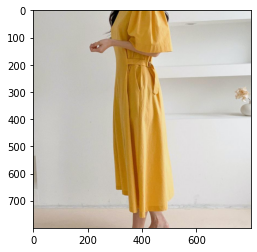

In [ ]:
#feminine, natural
filename = "/content/220731.jpg"

img = Image.open(filename).convert('RGB')

plt.imshow(img)

if val_transform is not None:
    
    img = val_transform(img)

wordvec = "/content/drive/MyDrive/kfashion_model/custom_glove_word2vec_final.pkl"

with open(wordvec, 'rb') as f:
    inp = pickle.load(f)

img = img.unsqueeze(0)
inp = torch.tensor(inp).unsqueeze(0)

feature_var = torch.autograd.Variable(img).float()
inp_var = torch.autograd.Variable(inp).float().detach()  # one hot

model.eval()

output = model(feature_var, inp_var)
percentage_output = F.softmax(output, dim = 1)


pred = output.cpu().detach().numpy()

sorted_pred = np.argsort(pred,axis = 1)

for i in range(9,-1,-1):
    
    print(f"top {10-i}: {change_category[sorted_pred[0][i]]}, conf:{percentage_output[0][sorted_pred[0][i]]*100:.4f}")

# inference data

In [ ]:
feature_var = torch.autograd.Variable(img).float()
inp_var = torch.autograd.Variable(inp).float().detach()  # one hot

model.eval()

output = model(feature_var, inp_var)


In [ ]:
output

tensor([[ -9.6854,  -0.7061,  -2.5424,  -9.1944,  -5.8106,  -6.4912,  -8.7202,
         -10.3212,  -1.9081,   8.0200]], grad_fn=<MmBackward0>)

In [ ]:
percentage_output = F.softmax(output, dim = 1)

In [ ]:
percentage_output

tensor([[2.0442e-08, 1.6226e-04, 2.5865e-05, 3.3402e-08, 9.8480e-07, 4.9859e-07,
         5.3671e-08, 1.0825e-08, 4.8775e-05, 9.9976e-01]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
output

tensor([[ -9.6854,  -0.7061,  -2.5424,  -9.1944,  -5.8106,  -6.4912,  -8.7202,
         -10.3212,  -1.9081,   8.0200]], grad_fn=<MmBackward0>)

In [ ]:
np.argsort(output.cpu().detach().numpy(),axis = 1)

array([[2, 3, 8, 4, 0, 1, 7, 6, 5, 9]])

In [ ]:
np.argsort(percentage_output.cpu().detach().numpy(),axis = 1)

array([[2, 3, 8, 4, 0, 1, 7, 6, 5, 9]])

In [ ]:
output[0][9]

tensor(3.0438, grad_fn=<SelectBackward0>)

In [ ]:
output[0][5]

tensor(-0.3158, grad_fn=<SelectBackward0>)

In [ ]:
output[0][6]

tensor(-2.0792, grad_fn=<SelectBackward0>)

In [ ]:
pred = output.cpu().detach().numpy()

sorted_pred = np.argsort(pred,axis = 1)

In [ ]:
for i in range(9,-1,-1):
    
    print(f"top {10-i}: {change_category[sorted_pred[0][i]]}, \n conf:{percentage_output[0][sorted_pred[0][i]]*100:.8f}")

top 1: casual, 
 conf:99.97616577
top 2: manish, 
 conf:0.01622591
top 3: subculture, 
 conf:0.00487747
top 4: feminine, 
 conf:0.00258650
top 5: contemporary, 
 conf:0.00009848
top 6: natural, 
 conf:0.00004986
top 7: genderless, 
 conf:0.00000537
top 8: ethnic, 
 conf:0.00000334
top 9: traditional, 
 conf:0.00000204
top 10: sporty, 
 conf:0.00000108


In [ ]:
#98463 answer: feminine, traditional
for i in range(9,-1,-1):
    
    print(f"top {10-i}: {change_category[sorted_pred[0][i]]}, conf:{percentage_output[0][i]*100:.8f}")

top 1: feminine, conf:0.00000524
top 2: traditional, conf:0.00007332
top 3: contemporary, conf:0.00000000
top 4: subculture, conf:0.00000000
top 5: casual, conf:0.00000000
top 6: manish, conf:0.00009145
top 7: ethnic, conf:0.00000032
top 8: natural, conf:98.11611938
top 9: genderless, conf:0.00000192
top 10: sporty, conf:1.88370883


In [ ]:
#185204 answer: natural, genderless

for i in range(9,6,-1):
    
    print(f"top {10-i}: {change_category[sorted_pred[0][i]]}, conf:{percentage_output[0][i]*100:.8f}")

top 1: casual, conf:98.34577942
top 2: manish, conf:0.17531787
top 3: genderless, conf:0.33098057


In [ ]:
class load_data(Data.Dataset):
    def __init__(self, root, phase='train', inp_name=None):
        self.root = root
        self.phase = phase
        self.img_list = []
        self.get_anno()
        self.num_classes = len(self.cat2idx)

        with open(inp_name, 'rb') as f:
            self.inp = pickle.load(f)

        self.inp_name = inp_name

    def get_anno(self):
        list_path = os.path.join(self.root, '{}_anno_custom_final_0.json'.format(self.phase))
        self.img_list = json.load(open(list_path, 'r'))
        self.cat2idx = json.load(open(os.path.join(self.root, 'category_custom_final.json'), 'r'))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        item = self.img_list[index]
        return self.get(item)

    def get(self, item):
        filename = "/content/drive/MyDrive/kfashion" + item['file_name'][2:]
        labels = sorted(item['labels'])

        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        target = np.zeros(self.num_classes, np.float32) - 1
        target[labels] = 1
        return (img, filename, self.inp), target

# test

In [ ]:
def on_end_epoch(p, r):
    
    pred = p.cpu().detach().numpy()
    real = r.cpu().detach().numpy()
    a, s_id, w_id, pp = top_n_recall(pred, real, 3)

    s = np.array(s_id)
    w = np.array(w_id)

    img_list = json.load(open('/content/drive/MyDrive/kfashion_model/test_anno_custom_final_0.json', 'r'))
    img_name_list = [x['file_name'] for x in img_list]

    l_r_s = real[s]
    l_p_s = pp[s]
    df = pd.DataFrame(np.array(img_name_list)[s])
    df['real'] = list(l_r_s)
    df['pred'] = list(l_p_s)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_correct_3.csv')

    l_r_w = real[w]
    l_p_w = pp[w]
    df = pd.DataFrame(np.array(img_name_list)[w])
    df['real'] = list(l_r_w)
    df['pred'] = list(l_p_w)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_wrong_3.csv')

    b, s_id, w_id, pp = top_n_recall(pred, real, 5)

    s = np.array(s_id)
    w = np.array(w_id)

    l_r_s = real[s]
    l_p_s = pp[s]
    df = pd.DataFrame(np.array(img_name_list)[s])
    df['real'] = list(l_r_s)
    df['pred'] = list(l_p_s)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_correct_5.csv')

    l_r_w = real[w]
    l_p_w = pp[w]
    df = pd.DataFrame(np.array(img_name_list)[w])
    df['real'] = list(l_r_w)
    df['pred'] = list(l_p_w)
    df.columns = ['img', 'real', 'pred']
    df.to_csv('content/output/style_wrong_5.csv')

    return round(a, 4), round(b, 4)

In [ ]:
# define train and val transform
test_dataset.transform = val_transform
#test_dataset.target_transform = val_target_transform

# data loading code
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size, shuffle=False,
                                          num_workers=workers)

# optionally resume from a checkpoint
if resume is not None:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume, map_location=torch.device('cpu'))
        
        start_epoch = checkpoint['epoch']
        
        best_score = checkpoint['best_score']
        
        model.load_state_dict(checkpoint['state_dict'])

    else:
        print("=> no checkpoint found at '{}'".format(resume))


if use_gpu:
    test_loader.pin_memory = True
    cudnn.benchmark = True

    model = torch.nn.DataParallel(model, device_ids=device_ids).cuda()
    criterion = criterion.cuda()

model.eval()

if use_pb:
        
    data_loader = tqdm(test_loader, desc='Test')

    for i, (input, target) in enumerate(data_loader):
        # measure data loading time
        target_gt = target.clone()

        target[target == 0] = 1
        target[target == -1] = 0

        feature =  input[0]
        out =  input[1]
        input = input[2]

        if use_gpu:
            
            target = target.cuda()
        
        feature_var = torch.autograd.Variable(feature).float()
        target_var = torch.autograd.Variable(target).float()
        inp_var = torch.autograd.Variable(input).float().detach()  # one hot

        with torch.no_grad():
            # compute output
            output = model(feature_var, inp_var)
            loss = criterion(output, target_var)
        
        print(loss)
    
    a, b = on_end_epoch(output, target)
    
    print('Top-3 recall:', a)
    print('Top-5 recall:', b)

In [ ]:
test_dataset[0]

((tensor([[[2.2147, 2.2147, 2.2318,  ..., 1.6667, 1.6667, 1.6324],
           [2.2147, 2.2147, 2.2318,  ..., 1.6667, 1.6667, 1.6324],
           [2.2318, 2.2318, 2.2318,  ..., 1.6667, 1.6495, 1.6495],
           ...,
           [1.1015, 1.1187, 1.1358,  ..., 1.0673, 1.0844, 1.0844],
           [1.1015, 1.1015, 1.1187,  ..., 1.0673, 1.0844, 1.0844],
           [1.0673, 1.0673, 1.0844,  ..., 1.0673, 1.0502, 1.0502]],
  
          [[2.4286, 2.4286, 2.4286,  ..., 1.8508, 1.8508, 1.8158],
           [2.4286, 2.4286, 2.4286,  ..., 1.8508, 1.8508, 1.8158],
           [2.4286, 2.4286, 2.4286,  ..., 1.8508, 1.8333, 1.8333],
           ...,
           [1.2381, 1.2556, 1.2731,  ..., 1.2031, 1.2206, 1.2206],
           [1.2381, 1.2381, 1.2556,  ..., 1.2031, 1.2206, 1.2206],
           [1.2031, 1.2031, 1.2206,  ..., 1.2031, 1.1856, 1.1856]],
  
          [[2.6226, 2.6226, 2.6400,  ..., 2.0997, 2.0997, 2.0648],
           [2.6226, 2.6226, 2.6400,  ..., 2.0997, 2.0997, 2.0648],
           [2.6400, 2.

In [ ]:
input,target = test_dataset[4][0],test_dataset[4][1]

In [ ]:
target[target == 0] = 1
target[target == -1] = 0

In [ ]:
target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
feature = input[0]
out = input[1]
input = input[2]

In [ ]:
input.shape

(10, 300)

In [ ]:
    for i, (input, target) in enumerate(data_loader):
        # measure data loading time
        target_gt = target.clone()

        target[target == 0] = 1
        target[target == -1] = 0

        feature =  input[0]
        out =  input[1]
        input = input[2]

        if use_gpu:
            
            target = target.cuda()
        
        feature_var = torch.autograd.Variable(feature).float()
        target_var = torch.autograd.Variable(target).float()
        inp_var = torch.autograd.Variable(input).float().detach()  # one hot

        with torch.no_grad():
            # compute output
            output = model(feature_var, inp_var)
            loss = criterion(output, target_var)

In [ ]:
out

'/content/drive/MyDrive/kfashion/img/K-fashion(1)/48076/1ROHA_030_09.jpg'

In [ ]:
feature_var = torch.autograd.Variable(feature.unsqueeze(0)).float()
target_var = torch.autograd.Variable(torch.tensor(target).unsqueeze(0)).float()
inp_var = torch.autograd.Variable(torch.tensor(input).unsqueeze(0)).float().detach()  # one hot

In [ ]:
output = model(feature_var, inp_var)

In [ ]:
output

tensor([[-10.2755, -14.1925,   2.9127, -12.4634,   7.0986, -16.3995, -14.4689,
         -10.9614,  -7.9354, -11.7380]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [ ]:
target_var

tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:
feature_var.dim()

3

In [ ]:
pred = output.cpu().detach().numpy()
real = torch.tensor(target).unsqueeze(0).cpu().detach().numpy()

In [ ]:
real

array([[0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
pred

array([[-10.27549 , -14.192515,   2.912665, -12.463433,   7.098566,
        -16.399544, -14.468911, -10.961401,  -7.935378, -11.737972]],
      dtype=float32)

In [ ]:
np.argsort(pred,axis=1)[:,-3:][0,:]

array([8, 2, 4])

In [ ]:
np.argmax(real,axis=1).shape[0]

1

In [ ]:
real

array([[0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
def top_n_recall(preds, truths, n=1):
    best_n = np.argsort(preds, axis=1)[:,-n:]
    ts = np.argmax(truths, axis=1)
    successes = 0
    s_img_id = []
    w_img_id = []
    for i in range(ts.shape[0]):
        if ts[i] in best_n[i,:]:
            successes += 1
            s_img_id.append(i)
        else:
            w_img_id.append(i)

    return float(successes)/ts.shape[0], s_img_id, w_img_id, best_na

In [ ]:
    best_n = np.argsort(preds, axis=1)[:,-n:]
    ts = np.argmax(truths, axis=1)